# Plot the closure of $\chi_{\perp}$ (read) by $u_{\perp}$ (calc)
See *plot_uchidotn_bothcalc.ipynb*

In [1]:
clear
homedir = getenv('HOME');
workdir = getenv('WORK');
scradir = getenv('SCRATCH');
addpath(genpath([homedir '/work_MOM']));
addpath(genpath([homedir '/mytoolbox']));
addpath(genpath([homedir '/MyFuncs']));

In [2]:
%-------- dir for  
tmStr = '_180d';
grid_dir = [workdir '/MOM6_exp/mom_lowRES/'];  
exp_dir = [workdir '/MOM6_OUT/tr_off_64' tmStr '/'];
chi_dir = [workdir  '/MOM6_OUT/tr_off_64' tmStr '/params/lmddotn_SIGNxmean_ka400_usesol_prog_addreld10/C09/'];
% 
h_dir = [workdir '/MOM6_OUT/forc_uvh_64/sol_h' tmStr '/'];
uvh_dir = [workdir '/MOM6_OUT/forc_uvh_64/uvhm_CS_decomp' tmStr '/'];
tr_dir = [exp_dir 'sols_pt/tr_forcprog_addrel10d_ptrel/'];

dt_flxmean = 6/24;

% ------ time
yr_s = 21;
[day_s, day_e, dt] = deal(1, 730, 1); % 6/24
t_al = day_s:dt:day_e;
nt_al = length(t_al);
fprintf(1,'Will do time = Y%s D%s-D%s.\n',num2str(yr_s), num2str(t_al(1)), num2str(t_al(end)) );

%-------- read model grid
[grid, ~, ~] = read_grid_MOM([grid_dir '']); % SOLUTION/
nk = length(grid.Layer);


Will do time = Y21 D1-D730.


In [3]:
[chin_t,un_t,undir_t] = deal(zeros(grid.nih,grid.njh,nk,nt_al));

for it = 1:nt_al

    [t1, t2] = deal(t_al(it), t_al(it)+dt_flxmean);
    t15 = (t1 + t2)/2;
    [yrstr, dystr, hrstr] = get_timestr(t1, yr_s);
    [yrstr15, dystr15, hrstr15] = get_timestr(t15, yr_s); 
    
    %---- read
    chin_fnm = [chi_dir 'K__' yrstr '_' dystr '_' hrstr '.nc'];
    h_fnm = [h_dir 'h_snap__' yrstr '_' dystr '_' hrstr '.nc'];
    flx_fnm = [uvh_dir 'uvh_mean__' yrstr15 '_' dystr15 '_' hrstr15 '.nc'];
    tr_fnm = [tr_dir 'tr__' yrstr '_' dystr '_' hrstr '.nc'];
    ds_chi = ncstruct(chin_fnm);
    ds_h = ncstruct(h_fnm);
    ds_uvh = ncstruct(flx_fnm);
    ds_tr = ncstruct(tr_fnm);
    %
    chidotn = ds_chi.chidotn;
    % chidotn = filter_extreme(chidotn,1,99);
    chin_t(:,:,:,it) = chidotn;
    
    %--- get u_perp
    for ik = 1:nk
        [uh, vh] = deal(ds_uvh.uh(:,:,ik)./grid.dyCu, ds_uvh.vh(:,:,ik)./grid.dxCv);
        h = ds_h.h(:,:,ik);
        c = ds_tr.tr1(:,:,ik);
        % on p
        [uh_p, vh_p] = uv2p_CG(uh, vh);
        [up, vp] = deal(uh_p./h, vh_p./h);
        
        % 
        [hcx,hcy] = calc_GxGy_CG(c,h,grid.dxCu,grid.dyCu,grid.dxCv,grid.dyCv,0);
        hcx([1 end],:) = 0; hcy(:,[1 end]) = 0;
        [hcx_p,hcy_p] = uv2p_CG(hcx,hcy);
        hcgrad_norm = sqrt(hcx_p.^2 + hcy_p.^2);
        [nx, ny] = deal(hcx_p ./ hcgrad_norm, hcy_p ./ hcgrad_norm); 
        
        % sign
        hcy_xmean = mean(hcy_p,1);
        sign2d = sign( repmat(hcy_xmean, [grid.nih 1]) );
        % sign2d = 1;
        
        % indirect method = (div{Uc}-c*divU)/|h*delc| [m/s]
        [uc, vc] = calc_TFluxes_CG(uh, vh, c, '2nd_order');
        divuc = calc_div_CG(uc, vc, grid.dyCu,grid.dxCv,grid.dxT,grid.dyT, 1);
        cdivu = c .* calc_div_CG(uh, vh, grid.dyCu,grid.dxCv,grid.dxT,grid.dyT, 1);
        udelc = divuc - cdivu;
        udotn = udelc ./ hcgrad_norm ./ sign2d;
        % dir method (similar to indirect method)
        udotn_dir = (up.*nx + vp.*ny) .* sign2d;
        
        un_t(:,:,ik,it) = udotn;
        undir_t(:,:,ik,it) = udotn_dir;
    end
end

## time smooth $\chi_{\perp}$ and $u_{\perp}$

In [4]:
t_dim = 4;
% slide-mean to eliminate noises
win_dy = 5; % window len in [day] 
win_hf = (win_dy/dt) / 2; % # of data points in half of the window (even)
chin_t_sld = movmean(chin_t, [win_hf, win_hf], t_dim);
udotn_t_sld = movmean(un_t, [win_hf, win_hf], t_dim);
udotndir_t_sld = movmean(undir_t, [win_hf, win_hf], t_dim);

## get GS core

In [5]:
ds_GS = load('GScore_mom_unsm_wide.mat'); % GScore_mom_unsm_wide or GScore_mom_5yr
[ii_GS, jj_GS] = deal(ds_GS.ii, ds_GS.jj);
[x_GSC_t, y_GSC_t, id_lat_spdt] = deal(zeros(length(ii_GS),nt_al));
for it = 1:nt_al
    it_ds = find(t_al(it) == ds_GS.t_al);
    id_lat_spdt(:,it) = ds_GS.id_lat_spdt(:,it_ds);
    x_GSC_t(:,it) = ds_GS.x_GSC_t(:,it_ds);
    y_GSC_t(:,it) = ds_GS.y_GSC_t(:,it_ds);
end
x_GSC_m = ds_GS.x_GSC_m;
y_GSC_m = ds_GS.y_GSC_m;

## CORR of $\chi_{\perp}$ and $u_{\perp}$

In [6]:
dim = 4;

% --- corr over time
it_cor = 1:nt_al;
[corr3d_chinun, slp3d, intcp3d, r2, pval] = deal(zeros(grid.nih,grid.njh,nk));

for ik = 1:nk
    [un_3d, chin_3d] = deal( udotn_t_sld(:,:,ik,it_cor), chin_t_sld(:,:,ik,it_cor) );
    [un_3d, chin_3d] = deal( squeeze(un_3d), squeeze(chin_3d) );
    corr3d_chinun(:,:,ik) = corr_array(un_3d,chin_3d,3);
end

## data

In [7]:
% savename = [homedir '/work_MOM/data_for_figure/closure_chi_u.nc'];

% % save nc
% dim_name = {'xh','yh','zl','Time'};
% dim_length = [grid.nih, grid.njh, nk, 1];
% varname = {'alpha','corr'};
% dimNum_of_var = {[1,2,3,4],[1,2,3,4]};
% data = {slp3d,corr3d_chinun};

% global_att  = ['chi_perp = -alpha * u_perp'...
%             't_al(1)='  num2str(t_al(1)) '; t_al(end)='  num2str(t_al(end)) ...
%             '; chi_dir=' chi_dir '; h_dir=' h_dir '; uvh_dir=' uvh_dir '; tr_dir=' tr_dir ];
% FUN_nc_easywrite_enhanced( savename, dim_name, dim_length,...
%     varname, dimNum_of_var, data, global_att )
 

## plot their meridional sections

find the non-dimensional factor $\alpha$ that minimizes the loss function 
- $\int|| \chi_{\perp} + \alpha u_{\perp} || \, dy$

In [8]:
[x, y] = deal(grid.lonh, grid.lath);
% 
ik = 1;
mean_chi = nanmean(chin_t(:,:,ik,:), dim); 
mean_un = nanmean(un_t(:,:,ik,:), dim); % udotndir_t_sld udotn_t_sld

fy_chi = mean(mean_chi,1);
fy_u = mean(mean_un,1); 

% ------------ find alpha in a certain latitude band ------------------
ylims = [1600 2250];  
[~, jj_s] = min(abs(y - ylims(1))); [~, jj_e] = min(abs(y - ylims(2)));
[f1, f2] = deal(fy_chi(jj_s:jj_e), -fy_u(jj_s:jj_e));

% ----- find the ratio that minimizes the loss function
fun = @(x)mismatch_func(x,f1,f2);
x0 = 1.0;
opt = optimset('Display','none', 'MaxIter',1e3, 'MaxFunEvals',1e3, 'TolFun', 1e-7, 'TolX', 1e-7);
% do minminization
[alpha,fval,exitflag,output] = fminsearch(fun,x0,opt); % [x,fval,exitflag,output] = fminunc(fun,x0,opt);
% 
alpha_1d = zeros(size(fy_u));
alpha_1d(jj_s:jj_e) = alpha;
% alpha_1d(:) = alpha;
fy_chi_pred = -alpha_1d.*fy_u;


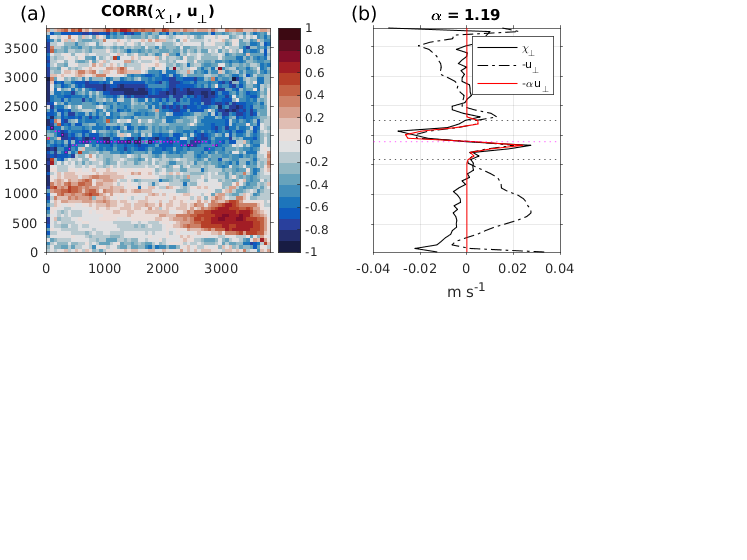

In [9]:
x1 = 0.05; y1 = 0.55; w1 = 0.4; h1 = w1;
x2 = x1+w1+0.05; y2 = y1; w2 = 0.25; h2 = h1;

pos1 = [x1 y1 w1 h1];
pos2 = [x2 y2 w2 h2];
[x, y] = deal(grid.lonh, grid.lath);
ik = 1;

% ------------------------------ plot
font = 'DejaVu Sans';
figure('DefaultTextFontName', font, 'DefaultAxesFontName', font);
% ----- left 2d map
clim = [-1 1];
ax = subplot('Position',pos1);
imagescn(x, y, corr3d_chinun(:,:,ik)'); axis square; set(gca,'tickdir','out');
% set(gca,'xticklabel','')
caxis(clim);
cmap = cmocean('balance',20);
colormap(cmap);
% title('$\textrm{Corr}(\textrm{u}_{\perp},\, \chi_{\perp})$','Interpreter','latex','fontsize',14)
title('CORR(\chi_{\perp}, u_{\perp})')

hold on; scatter(x_GSC_m, y_GSC_m, 10,'.m')
cb = colorbar;
cb.XTick = clim(1):.2:clim(2);
% cb.Position = [cb.Position(1)+0.04 cb.Position(2) 0.02 cb.Position(4)];

% ----- right y-profile
ax = subplot('Position',pos2);
plot(fy_chi, y, 'k-', 'linewidth', .8);
hold on
plot(-fy_u, y, 'k-.', 'linewidth', .8);
hold on
plot(fy_chi_pred, y, 'r-', 'linewidth', .8);

ax = gca;
ax.XGrid = 'on'; ax.YGrid = 'on';
ax.XLim = [-1 1]*0.04;
ax.YLim = y([1 end]);
ax.YTickLabel = '';
ax.TickDir = 'out';
hold on; hline(mean(y_GSC_m),':m','HandleVisibility','off');
hold on; hline(y(jj_s),':k','HandleVisibility','off');
hold on; hline(y(jj_e),':k','HandleVisibility','off');
legend('\chi_{\perp}','-u_{\perp}','-\alphau_{\perp}','fontsize',8)
title(['\alpha = ' num2str(alpha,'%3.2f')])
xlabel('m s^{-1}')

hb = subplotlabel(gcf,'a','location','northwestoutside','offset',[-0.12 0.01],'Prefix','(','Postfix',')');

% ---
set(gcf,'PaperPositionMode','auto'); 
fignm = [homedir '/work_MOM/figures/fig13_closure_chi_u'];
% exportgraphics(gcf,[fignm '.pdf'], 'BackgroundColor','white','ContentType','vector')

## extended to 2d map

In [30]:
[chin_3d] = deal(zeros(grid.nih, grid.njh, nk));
ii_do = 1:length(y_GSC_m);
j_pred_0cros = 37;

fy_chi_pred_ext = [zeros(1,5) fy_chi_pred zeros(1,5)];

for ik = 1:nk
    for i = ii_do
        [~, j_GSC_temp] = min(abs(y - y_GSC_m(i)));
        
        %-- at core
        chin_3d(i,j_GSC_temp,ik) = 0;
        
        %-- north
        jj = j_GSC_temp+1:grid.njh;
        jj_pred = j_pred_0cros : j_pred_0cros + length(jj)-1;
        chin_3d(i,jj,ik) = fy_chi_pred_ext(jj_pred);
        
        %-- south
        jj = 1:j_GSC_temp-1;
        jj_pred = j_pred_0cros-length(jj):j_pred_0cros-1;
        chin_3d(i,jj,ik) = fy_chi_pred_ext(jj_pred);
    end
end

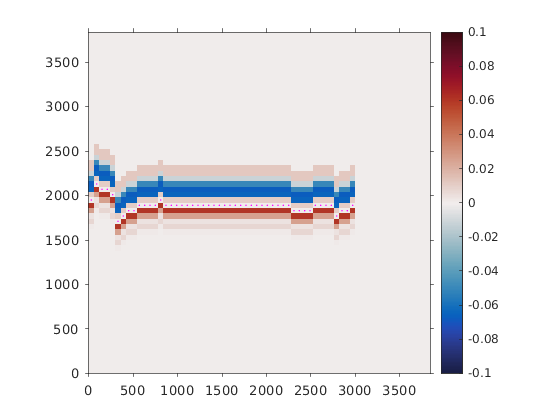

In [31]:
ik = 1;
clim = [-1 1]*1e-1;
figure
imagescn(x, y, chin_3d(:,:,ik)'); axis square; set(gca,'tickdir','out');
caxis(clim); cmocean('balance'); colorbar
hold on; scatter(x_GSC_m, y_GSC_m,6,'.m')

## save to .nc

In [32]:
savename = [workdir '/MOM6_OUT/tr_off_64_180d/params/ideal_prof/chinxyz_closure1d_alpha2.nc'];

%------------------------ save nc
dim_name = {'xh','yh','zl','Time'};
dim_length = [grid.nih, grid.njh, nk, 1];
varname = {'chidotn'};
dimNum_of_var = {[1,2,3,4]};
data = {chin_3d};

global_att  = ['chi_perp = -alpha)*TXmean(u_perp)(y) -> extend 2d; '...
            't_al(1)='  num2str(t_al(1)) '; t_al(end)='  num2str(t_al(end)) ...
            '; dt=' num2str(dt) '; alpha=' num2str(alpha)];
FUN_nc_easywrite_enhanced( savename, dim_name, dim_length,...
    varname, dimNum_of_var, data, global_att )